# Sentiment Analysis on IMDB 50K Movie Reviews Dataset
- EDA 
-LSTM Model

## Importing Libraries

In [1]:
import re
import nltk
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dropout, Dense
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score


plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'

## Loading Dataset

In [2]:
data = pd.read_csv("/content/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Data Analysis

In [3]:
import plotly.graph_objects as go

colors = ['#8EB897', '#B7C3F3']
fig = go.Figure(data=[go.Pie(labels=['Positive','Negative'], values=data['sentiment'].value_counts(), hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(title='Balanced Dataset')
fig.show()

In [4]:
# counting the word count
data['count']=data['review'].apply(lambda x:len(x.split()))

In [5]:
import plotly.express as px

fig = px.histogram(data, x='count', nbins=50, color_discrete_sequence=['#8EB897'],
                   title='Word_count Distribution in a review')
fig.update_layout(title_x=0.5)
fig.show()


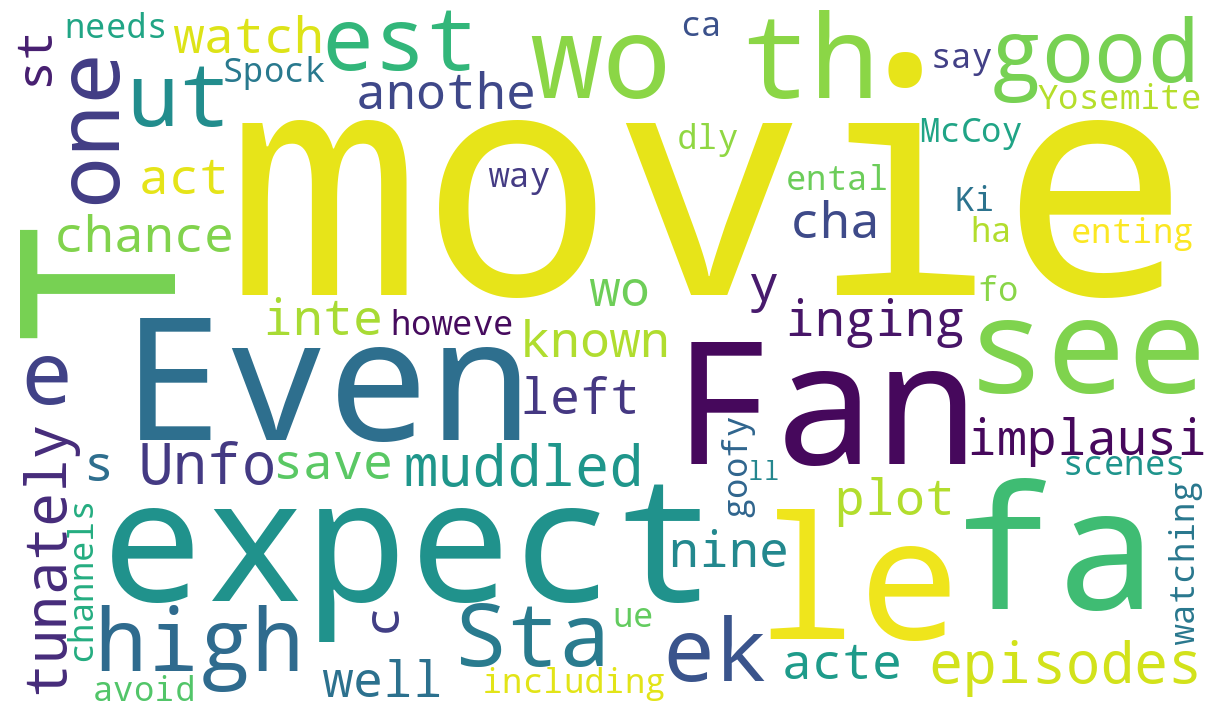

In [6]:
#  commonly seen negative words in review

neg_list=data.loc[data['sentiment']=='negative','review'].tolist()
neg_text=""
for i in neg_list:
    i=re.sub("[<br>]"," ",i)
    neg_text=re.sub("[^A-Za-z0-9]+"," ",i)
    neg_text+=i    

stopwords=set(STOPWORDS)
wordcloud_neg = WordCloud(width=1200,height=700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(neg_text)
 
# plot the WordCloud image                      
plt.figure(figsize = (12, 7), facecolor = None)
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

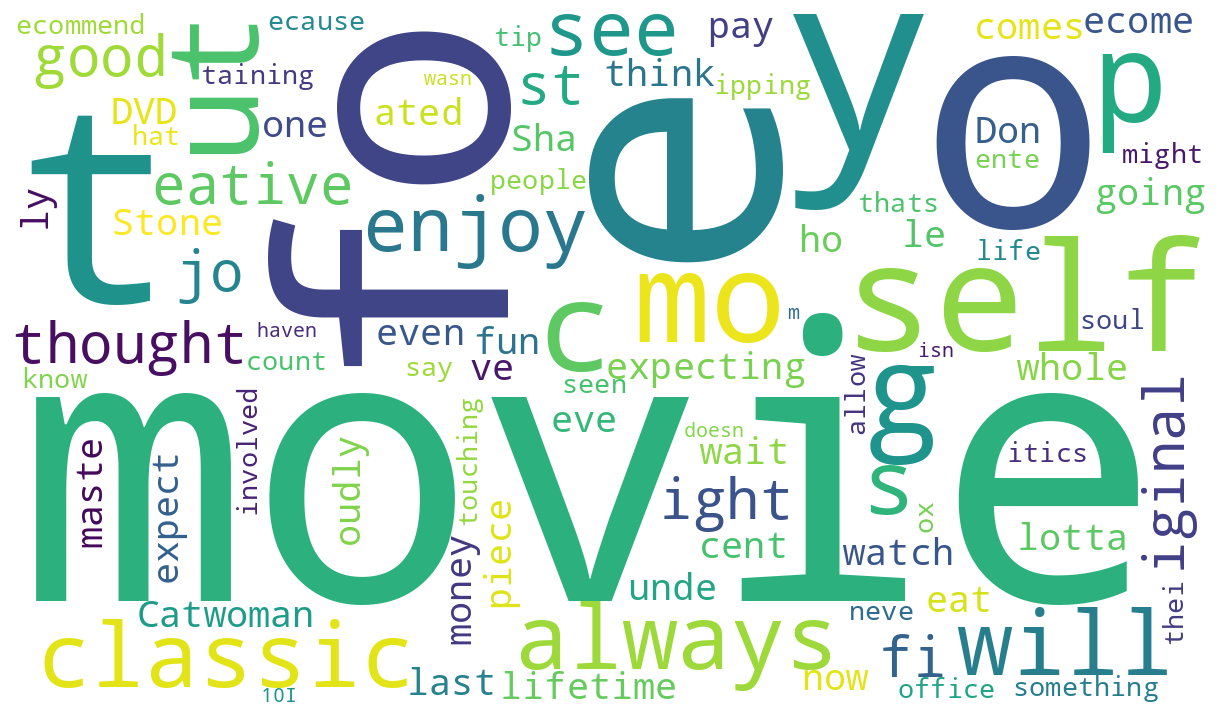

In [7]:
#commonly used positive words in review

positive_list=data.loc[data['sentiment']=='positive','review'].tolist()
pos_text=""
for i in positive_list:
    i=re.sub("[<br>]"," ",i)
    pos_text=re.sub("[^A-Za-z0-9]+"," ",i)
    pos_text+=i    

stopwords=set(STOPWORDS)
wordcloud_positive = WordCloud(width=1200,height=700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(pos_text)
 
# plot the WordCloud image                      
plt.figure(figsize = (12, 7), facecolor = None)
plt.imshow(wordcloud_positive)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [8]:
# Function that converts sentiment values into numeric values

def senti_val(value):
    if value=='positive': 
        return 1
    else: 
        return 0
    
data['sentiment']  =  data['sentiment'].apply(senti_val)

data.head()

,review,sentiment,count
0,One of the other reviewers has mentioned that ...,1,307
1,A wonderful little production. <br /><br />The...,1,162
2,I thought this was a wonderful way to spend ti...,1,166
3,Basically there's a family where a little boy ...,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230


# Data preprocessing  <br>
 transformations of the regular expressions to base words to the reviews:<br>



In [9]:
#randomly choosing one 
idx = random.randint(0, len(data)-1)
sample_eg = data.iloc[idx][0] # Here we store a random example of review before the transformation process
#function performs the transformations 
def trans_rev(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

data['review'] = data['review'].apply(lambda x: trans_rev(x))
samp_af_trans = data.iloc[idx][0] # after the transformation its been stored

In [10]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
#english words by nltk and assign to eng_stop_set
eng_stop_set = set(nltk.corpus.stopwords.words('english'))
#function to remove the stop words in the review
def del_stop(x):
    words = nltk.tokenize.word_tokenize(x)
    filtered_list = [word for word in words if word not in eng_stop_set]
    return ' '.join(filtered_list)

data['review'] = data['review'].apply(lambda x: del_stop(x))
rev_del = del_stop(samp_af_trans)# finally after the removal of stopwords

In [12]:

print('After being processing\n',rev_del)

After being processing
 odd film liked adventure though seems aimed children spoiler ahead ironically main character murders federal official fugitive run later blow house finally commits suicide seems like made film mature audience made family friendly odd film liked adventure though seems aimed children spoiler ahead ironically main character murders federal official fugitive run later blow house finally commits suicide seems like made film mature audience made family friendly


# Data Splitting

In [13]:
#Splitting the data into train set and test set
train_x, test_X, train_y, test_Y = train_test_split(data['review'], data['sentiment'], test_size=0.2, random_state=42)

print( train_x.shape)
print(test_X.shape)
print(train_y.shape)
print(test_Y.shape)

(40000,)
(10000,)
(40000,)
(10000,)


-Creating a tokenizer object using the Tokenizer class from the 'keras.preprocessing.text'module.
- creating a 'tok_dict',setting 3500 most frequent used words

In [14]:
tok_dict = 35000 # 
tokenizer = Tokenizer(num_words=tok_dict)
tokenizer.fit_on_texts(data['review'])# list of strings containing  the text data being tokenized

print("Dictionary size is :" ,tok_dict)
print("Tokenizer index length is:" ,len(tokenizer.word_index))# number of unique words,after being tokenized
print("Documents the tokenizer being trained on:", {tokenizer.document_count})
print(" 10 entries of the tokenizer index:")
for i, (word, index) in enumerate(tokenizer.word_index.items()):
    print(f"{word}: {index}", end=", ")
    if i == 9:
        break

Dictionary size is : 35000
Tokenizer index length is: 125791
Documents the tokenizer being trained on: {50000}
 10 entries of the tokenizer index:
movie: 1, film: 2, one: 3, like: 4, good: 5, time: 6, even: 7, would: 8, really: 9, story: 10, 

In [15]:
import pickle
with open('tokenzier.pkl', 'wb') as file_ref:
    pickle.dump(tokenizer, file_ref)

In [16]:
# texts_to_sequences() of the Tokenizer class
#converting the text data in train_x and test_X to sequence of integers
train_tok = tokenizer.texts_to_sequences(train_x)
test_tok= tokenizer.texts_to_sequences(test_X)
lengths_of_seq =  np.array([len(sequence) for sequence in train_tok]) #length of the sequence in train tokenizer

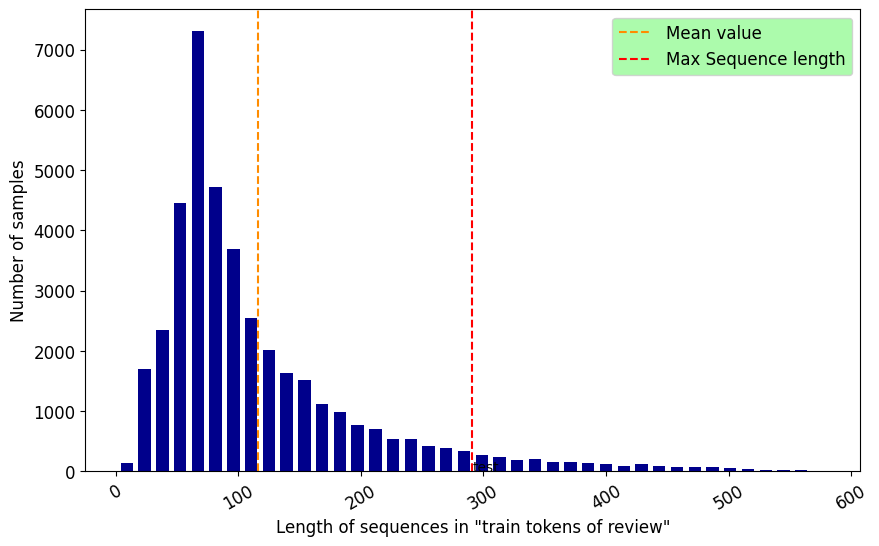

In [17]:

from scipy import stats
#calculating the mean and standard deviation of the sequence of length
mean = np.mean(lengths_of_seq) 
std = np.std(lengths_of_seq)
#calculating maximum sequence length
max_seq_length = int(mean + 2 * std)
#calculating the percentage of sequence where the length is smaller or equal to max length
percentile_max_length = stats.percentileofscore(lengths_of_seq, max_seq_length)
# Histogram plot of the length of the sequence in train tokenizer
fig, hist = plt.subplots(figsize=(10,6))
hist.hist(lengths_of_seq[lengths_of_seq < 2*max_seq_length], color='darkblue', bins=40, rwidth=0.7)
hist.axvline(np.mean(lengths_of_seq), color='darkorange', linestyle='--', label='Mean value')
hist.axvline(max_seq_length, color='r', linestyle='--', label='Max Sequence length')
plt.xlabel('Length of sequences in "train tokens of review"', size='large')
plt.ylabel('Number of samples', size='large')
plt.text(max_seq_length, 0, 'test')
plt.legend(fontsize='large', facecolor='palegreen')
plt.xticks(rotation=30)
plt.show()

In [18]:
#define a function 'pad_tokens(), which return the padded sequence 
def pad_tokens(tokens,maxlen):
  return pad_sequences(tokens,maxlen)
  #obtaining the pad sequence for the train and test reviews
train_pad = pad_tokens(train_tok,max_seq_length)
test_pad = pad_tokens(test_tok,max_seq_length)
#printing the shape of the padded train and test
print('\033[1m' + 'train_pad.shape:' + '\033[0m', train_pad.shape)
print('\033[1m' + 'test_pad.shape:' + '\033[0m', test_pad.shape, '\n')
#Pick a random index from train review sequence
idx_pad = random.randint(0,len(train_pad)-1)
#printing the corresponding padded review
print('\033[1m' + 'Review #%d after padding:' %idx_pad + '\033[0m' + '\n', train_pad[idx_pad])


train_pad.shape: (40000, 291)
test_pad.shape: (10000, 291) 

Review #9250 after padding:
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0    

# LSTM MODEL

In [19]:
# creating the LSTM model

output_dim = 14
units_lstm = 16
r = 0.8

model = Sequential()
model.add(Embedding(input_dim=tok_dict, output_dim=output_dim, input_length=max_seq_length))
model.add(LSTM(units_lstm))
model.add(Dropout(r))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 291, 14)           490000    
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 492,001
Trainable params: 492,001
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam', loss='bce', metrics='accuracy')

In [22]:
validation_split = 0.1
batch_size = 384
epochs = 2

fitted = model.fit(train_pad, train_y, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/2
94/94 [==============================] - 31s 251ms/step - loss: 0.6826 - accuracy: 0.6187 - val_loss: 0.6197 - val_accuracy: 0.7045
Epoch 2/2
94/94 [==============================] - 20s 213ms/step - loss: 0.4931 - accuracy: 0.8179 - val_loss: 0.3868 - val_accuracy: 0.8640


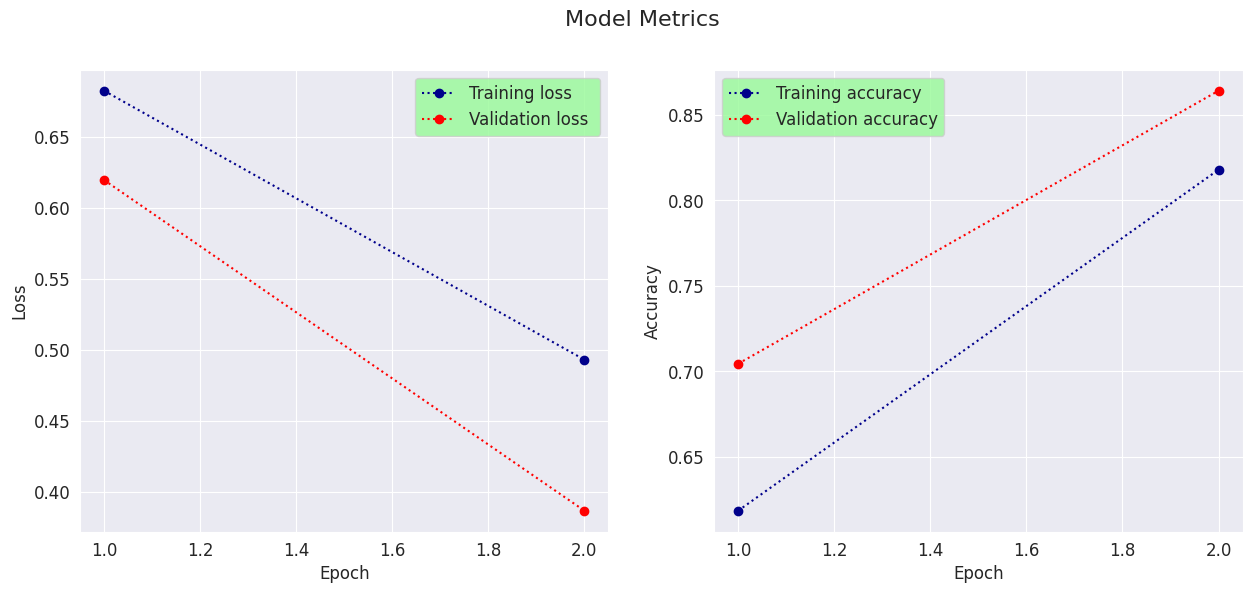

In [23]:
# "ep_values"----> the values of the epochs
epoch_values = range(1, epochs+1)

# Plot of the training loss and validation loss 
with sns.axes_style("darkgrid"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Model Metrics', fontsize=16)
    
    ax1.plot(epoch_values, fitted.history['loss'], color='darkblue', linestyle='dotted',
              marker='o', label='Training loss')
    ax1.plot(epoch_values, fitted.history['val_loss'], color='r', linestyle='dotted',
              marker='o', label='Validation loss ')
    ax1.set_xlabel('Epoch', size='large')
    ax1.set_ylabel('Loss', size='large')
    ax1.legend(fontsize='large', facecolor='palegreen')

    ax2.plot(epoch_values, fitted.history['accuracy'], color='darkblue', linestyle='dotted',
             marker='o', label='Training accuracy')
    ax2.plot(epoch_values, fitted.history['val_accuracy'], color='r', linestyle='dotted',
             marker='o', label='Validation accuracy')
    ax2.set_xlabel('Epoch', size='large')
    ax2.set_ylabel('Accuracy', size='large')
    ax2.legend(fontsize='large', facecolor='palegreen')

    plt.show()


In [24]:
result= model.evaluate(test_pad, test_Y)

313/313 [==============================] - 2s 6ms/step - loss: 0.3828 - accuracy: 0.8667


In [25]:
model.save('models/lstm')

In [26]:
model.save_weights('models/lstm_weights/')

In [27]:
model.load_weights('models/lstm_weights/')

In [28]:

def visualize_confusion_matrix(y_pred, y_true):
   

    cm = confusion_matrix(y_true, y_pred)
    con_mat_df = pd.DataFrame(cm)
    
    print(classification_report(y_pred, y_true))

    sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



In [29]:
y_pred = model.predict(test_pad)

313/313 [==============================] - 2s 5ms/step


              precision    recall  f1-score   support

           0       0.86      0.87      0.86      4862
           1       0.88      0.86      0.87      5138

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



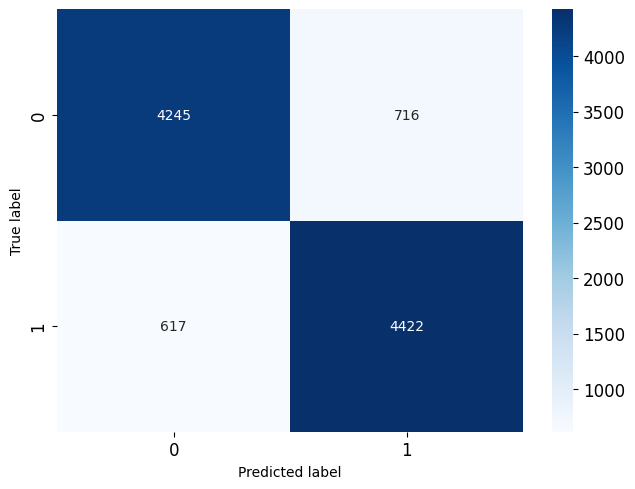

In [30]:
visualize_confusion_matrix(np.where(y_pred< 0.5, 0, 1), test_Y)

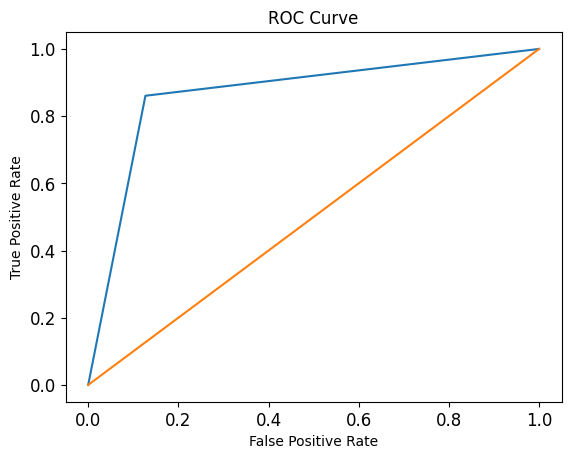

In [31]:
fpr,tpr,thresholds = roc_curve(np.where(y_pred< 0.5, 0, 1), test_Y)
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [32]:
roc_auc_score(np.where(y_pred< 0.5, 0, 1), test_Y)

0.8668718282839135